## Section 3 Cross-Validation and ROC curve analysis

Suppose we don't have access to the Kaggle leaderboard, we still have means to check how well we're doing with cross-validation. The process is as follows: we divide the data set into two, using the first to train our model and the second to make predictions. Since we have the actual outcomes in the second data set, we can use this as a basis of comparison and calculate the accuracy of our predictions. Dividing the data set into two is called 2-fold cross-validation, with each fold being the individual partitions of the data set. 

Cross-validation is best illustrated by an example. We'll load and process the Titanic training set as before.

In [1]:
import pandas as pd
import numpy as np

df = pd.read_csv('data/train.csv')

df = df.drop(['Name', 'Ticket', 'Cabin'], axis=1)

age_mean = df['Age'].mean()
df['Age'] = df['Age'].fillna(age_mean)

from scipy.stats import mode

mode_embarked = mode(df['Embarked'])[0][0]
df['Embarked'] = df['Embarked'].fillna(mode_embarked)

df['Gender'] = df['Sex'].map({'female': 0, 'male': 1}).astype(int)

pd.get_dummies(df['Embarked'], prefix='Embarked').head(10)
df = pd.concat([df, pd.get_dummies(df['Embarked'], prefix='Embarked')], axis=1)

df = df.drop(['Sex', 'Embarked'], axis=1)

cols = df.columns.tolist()
cols = [cols[1]] + cols[0:1] + cols[2:]

df = df[cols]

/Applications/CompTools/miniconda/lib/python2.7/site-packages/numpy/lib/arraysetops.py:200: FutureWarning: numpy not_equal will not check object identity in the future. The comparison did not return the same result as suggested by the identity (`is`)) and will change.
  flag = np.concatenate(([True], aux[1:] != aux[:-1]))


For convenience, we'll rename the feature columns of the training set as X, and the outcomes as y.

In [2]:
df.info()
train_data = df.values[:891]

X = train_data[:, 2:]
y = train_data[:, 0]

<class 'pandas.core.frame.DataFrame'>
Int64Index: 891 entries, 0 to 890
Data columns (total 11 columns):
Survived       891 non-null int64
PassengerId    891 non-null int64
Pclass         891 non-null int64
Age            891 non-null float64
SibSp          891 non-null int64
Parch          891 non-null int64
Fare           891 non-null float64
Gender         891 non-null int64
Embarked_C     891 non-null float64
Embarked_Q     891 non-null float64
Embarked_S     891 non-null float64
dtypes: float64(5), int64(6)
memory usage: 83.5 KB


We can generate cross-validation folds automatically with Scikit-learn. KFold divides our data set into the required number of folds.

In [3]:
from sklearn.cross_validation import KFold
from sklearn.ensemble import RandomForestClassifier

random_seed=1234
cv = KFold(n=len(train_data), n_folds=5, random_state=random_seed)

for training_set, test_set in cv:
    X_train = X[training_set]
    y_train = y[training_set]
    X_test = X[test_set]
    y_test = y[test_set]
    model = RandomForestClassifier(n_estimators=100)    
    model.fit(X_train, y_train)
    
    y_prediction = model.predict(X_test)
    print "Prediction accuracy:", np.sum(y_test == y_prediction)*1./len(y_test)

Prediction accuracy: 0.776536312849
Prediction accuracy: 0.797752808989
Prediction accuracy: 0.837078651685
Prediction accuracy: 0.775280898876
Prediction accuracy: 0.842696629213


It is important to note that, cross-validation is generally recommended across a larger number of folds, usually between 5 and 10.

### Stratified cross-validation and random seed control
Below stratified cross-validation is used, where the distribution of the class lables is kept the same for each fold.
Usually the stratified cross-validation is preferred over the non-stratified one. 

For fair comparison of various model types, you need to make sure the each model type was cross-validated using the same kfold split. To control the kfold split, the random seed needs to be controlled. 

### Get AUC and create ROC curves from cross-validation
Besides accuracy, the code below will also calculate AUC from each iteration of the CV. 
Note that for calculating meaningful AUC, a continuous output prediction should be used instead of discrete class label prediction. As AUC was obtained by taking into account all possible cut-off values for the binary classification over a contiuous output prediction. 
Many algorithms implemented in scikit-learn (e.g. naive_bayes, DecisionTreeClassifier, LogisticRegression, KNeighborsClassifier, SVC, randomForest, could all provide a probability output using method predict_proba, SVC could provide the decision score using method decision_function. 

Prediction accuracy: 0.787709497207
Area under ROC curve (AUC): 0.828524374177
Prediction accuracy: 0.815642458101
Area under ROC curve (AUC): 0.799011857708
Prediction accuracy: 0.842696629213
Area under ROC curve (AUC): 0.901069518717
Prediction accuracy: 0.775280898876
Area under ROC curve (AUC): 0.852807486631
Prediction accuracy: 0.83615819209
Area under ROC curve (AUC): 0.888356718834


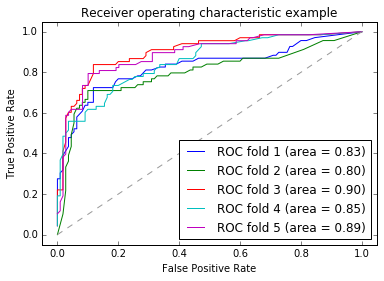

[ 0.7877095   0.81564246  0.84269663  0.7752809   0.83615819]
Mean Accuracy: 0.811 (+/- 0.052)
[ 0.82852437  0.79901186  0.90106952  0.85280749  0.88835672]
Mean AUC: 0.854 (+/- 0.074)


In [4]:
%matplotlib inline 
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
from sklearn.cross_validation import StratifiedKFold as SKFold
#from sklearn.naive_bayes import MultinomialNB, BernoulliNB, GaussianNB

random_seed = 1234
scv = SKFold(y=y, n_folds=5, random_state=random_seed)

mean_acc = 0.0
mean_auc = 0.0
all_tpr = []
all_acc = []
all_auc = []

i=0
for training_set, test_set in scv:
    i+=1
    X_train = X[training_set]
    y_train = y[training_set]
    X_test = X[test_set]
    y_test = y[test_set]
    model = RandomForestClassifier(n_estimators=100)
    model.fit(X_train, y_train)
    # Get prediction on class label from the model
    y_prediction = model.predict(X_test)
    
    # Get probability output from the model
    y_prob = model.predict_proba(X_test)
    acc = np.sum(y_test == y_prediction)*1./len(y_test)
    print "Prediction accuracy:", acc
    # Compute ROC curve and area the curve
    fpr, tpr, thresholds = roc_curve(y_test, y_prob[:, 1])
    roc_auc = auc(fpr, tpr)
    print "Area under ROC curve (AUC):", roc_auc
    plt.plot(fpr, tpr, lw=1, label='ROC fold %d (area = %0.2f)' % (i, roc_auc))    
    all_acc.append(acc)
    all_auc.append(roc_auc)

plt.plot([0, 1], [0, 1], '--', color=(0.6, 0.6, 0.6))#, label='Luck')
plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()

all_acc=np.asarray(all_acc)
all_auc=np.asarray(all_auc)
print(all_acc)
# print 95% C.I. for both accuracy and AUC based on CV
print("Mean Accuracy: %0.3f (+/- %0.3f)" % (all_acc.mean(), all_acc.std() * 1.96))
print(all_auc)
print("Mean AUC: %0.3f (+/- %0.3f)" % (all_auc.mean(), all_auc.std() * 1.96))

For more stuffs on on scikit-learn cross-validation, please see:
http://scikit-learn.org/stable/modules/cross_validation.html

Example of benchmarking different classification algorithms: 
http://scikit-learn.org/dev/auto_examples/text/document_classification_20newsgroups.html#example-text-document-classification-20newsgroups-py